# Generative Models as Data Augmentation in the Medical Domain

## 1. Overview

This project tries to evaluate the quality of generative models for data augmentation in the medical domain. 

Data augmentation will be relying on geometric data augmentation, (variational) auto-encoder (e.g. stacked denoising, denoising auto-encoder, etc.), and generative adversarial neural networks (e.g. GAN, DCGAN, Wasserstein GAN, etc.) for instance.

We will restrict ourself to three kind of models to generate new data and evaluate the (possible) improvement with regards to a final classification score (i.e. comparing results between augmented and non-augmented training sets). 

### Datasets

We will look into applying the above project on some (if not all) of the following datasets from the MedMNIST Classification Decathlon (https://medmnist.github.io/):

| Dataset | Classification Type | Train size | Validation size | Test size |
| :--- | :--- | :---: | :---: | :---: |  
| PathMNIST Pathology | Multi-Class (9) | 89,996 | 10,004 | 7,180 |
| DermaMNIST Dermatoscope | Multi-Class (7) | 7,007 | 1,003 | 2,005 |
| OCTMNIST OCT | Multi-Class (4) | 97,477 | 10,832 | 1,000 |
| PneumoniaMNIST Chest X-ray | Binary-Class (2) |4,708 | 524 | 624 |
| BreastMNIST Breast Ultrasound | Binary-Class (2) | 546 | 78 | 156 |
| OrganMNIST_Axial Abdominal CT | Multi-Class (11) | 34,581 | 6,491 | 17,778 |
| OragnMNIST_Coronal Abdominal CT | Multi-Class (11) |13,000 | 2,392 | 8,268 |
| OrganMNIST_Sagittal Abdominal CT | Multi-Class (11) | 13,940 | 2,452 | 8,829 |

### Notes

We will also provide a short report (in copy) explaining the choice of VAE, AE, and/or GAN models, outlining differences between datasets' results. We will also try to interprete and justify possible differences with regards to models, data specifications, visual features, and bibliography references used to support the choices made.

## 2. Data and Library Imports

### Source

We will retrieve the above dataset from the following website:

> [MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification](https://medmnist.com/), Jiancheng Yang,Rui Shi,Donglai Wei,Zequan Liu,Lin Zhao,Bilian Ke,Hanspeter Pfister,Bingbing Ni

By following the instructions on their [github](https://github.com/MedMNIST/MedMNIST), we can download their ready-made module with the following instruction:

```sh
pip install jupyter, ipywidgets, IProgress
pip install medmnist
```

And load it in a python or ipython instance:

```python
import medmnist
```

### Library Imports

In [5]:
from python_scripts.classifier import run_classifier_pipeline
from python_scripts.data import retrieve_flag_info, import_dataset
from python_scripts.data import check_cuda_availability

import warnings
warnings.filterwarnings('ignore')

### Checks CUDA availability

In [6]:
check_cuda_availability()

True,0,<torch.cuda.device object at 0x7f2213fc5460>,1
NVIDIA GeForce GTX 980 Ti


### Data Imports

In [7]:
data_flags = ["pathmnist", "dermamnist", "octmnist", "pneumoniamnist", 
              "breastmnist", "organamnist", "organcmnist", "organsmnist"]

info_flags = {flag:retrieve_flag_info(flag) for flag in data_flags}

Using downloaded and verified file: /home/quentin/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/pathmnist.npz
Montage of randomly extracted images from the dataset:


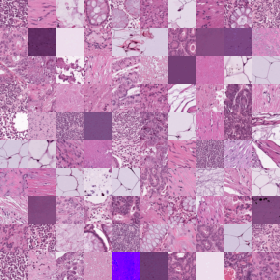

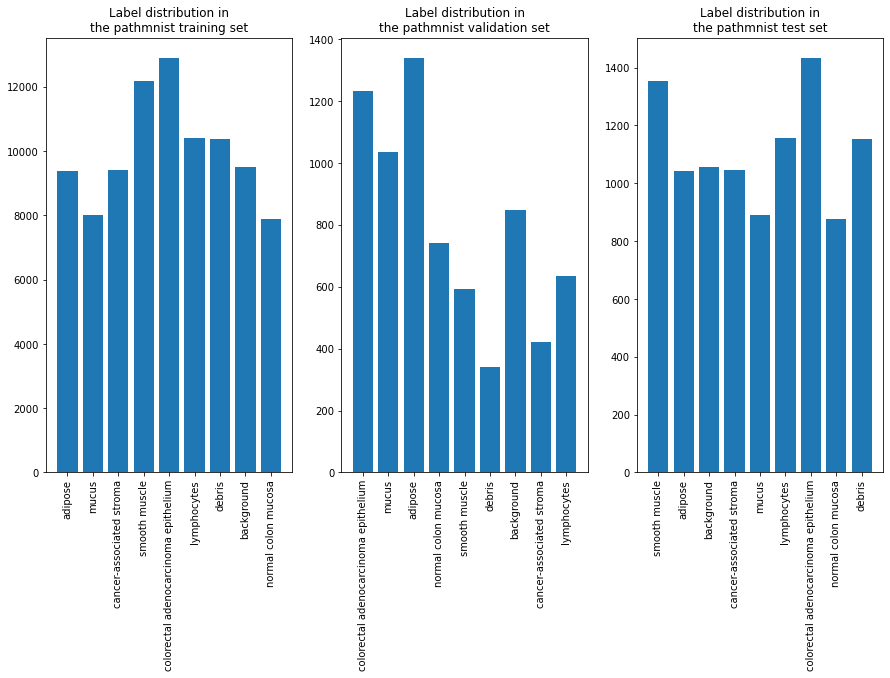

In [8]:
pathmnist = import_dataset("pathmnist", info_flags)

In [ ]:
dermamnist = import_dataset("dermamnist", info_flags)

In [ ]:
octmnist = import_dataset("octmnist", info_flags)

In [ ]:
pneumoniamnist = import_dataset("pneumoniamnist", info_flags)

In [ ]:
breastmnist = import_dataset("breastmnist", info_flags)

In [ ]:
organamnist = import_dataset("organamnist", info_flags)

In [ ]:
organcmnist = import_dataset("organcmnist", info_flags)

In [ ]:
organsmnist = import_dataset("organsmnist", info_flags)

## 3. Training a Classifier Without Data Augmentation

### PathMNIST

In [ ]:
clf_pathmnist = run_classifier_pipeline("pathmnist", info_flags, pathmnist)

### DermaMNIST

In [ ]:
clf_dermamnist = run_classifier_pipeline("dermamnist", info_flags, dermamnist)

### OctMNIST

In [ ]:
clf_octmnist = run_classifier_pipeline("octmnist", info_flags, octmnist)

### PneumoniaMNIST

In [ ]:
clf_pneumoniamnist = run_classifier_pipeline("pneumoniamnist", info_flags, pneumoniamnist)

### BreastMNIST

In [ ]:
clf_breastmnist = run_classifier_pipeline("breastmnist", info_flags, breastmnist)

### OrganAMNIST

In [ ]:
clf_organamnist = run_classifier_pipeline("organamnist", info_flags, organamnist)

### OrganCMNIST

In [ ]:
clf_organcmnist = run_classifier_pipeline("organcmnist", info_flags, organcmnist)

### OrganSMNIST

In [ ]:
clf_organsmnist = run_classifier_pipeline("organsmnist", info_flags, organsmnist)

In [245]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# cuda setup
device = torch.device("cuda")

class ConditionalVAE(nn.Module):
    """
    Implementation of a Conditional Variational Autoencoder inspired from
    the following implementations:
    > https://github.com/unnir/cVAE
    > https://github.com/AntixK/PyTorch-VAE
    """
    def __init__(self, in_channels, n_classes, latent_dims, img_size):
        super(ConditionalVAE, self).__init__()
        # Records the dimensional parameters
        self.channel_size = in_channels
        self.class_size = n_classes
        self.latent_dimensions = latent_dims
        self.hidden_layer_dimensions = [32, 64, 128, 256]
        self.fc_factor = 4
        self.image_size = img_size
        # Declares the layers of the CVAE encoder (Convolutional + FC)
        in_channels += 1
        encoder_modules = []
        for dim in self.hidden_layer_dimensions:
            print(in_channels, dim)
            encoder_modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=dim, 
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(dim), 
                    nn.ReLU()
                )
            )
            in_channels=dim
        # Declares the hidden layers of the CVAE decoder (Convolutional + FC)
        self.decoder_input = nn.Linear(latent_dims + n_classes, 
                                       self.hidden_layer_dimensions[-1]*self.fc_factor)
        decoder_modules = []
        for layer in range(len(self.hidden_layer_dimensions)-1,0,-1):
            print(self.hidden_layer_dimensions[layer], self.hidden_layer_dimensions[layer-1])
            decoder_modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        self.hidden_layer_dimensions[layer],
                        self.hidden_layer_dimensions[layer-1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1
                    ),
                    nn.BatchNorm2d(self.hidden_layer_dimensions[layer-1]),
                    nn.ReLU()
                )
            )
        # Declares the first layer of the decoder 
        self.decoder_input_layer = nn.Linear(
            latent_dims + n_classes,
            self.hidden_layer_dimensions[-1]*self.fc_factor
        )
        # Declares the final layer of the decoder
        self.decoder_output_layer = nn.Sequential(
            nn.Sequential(
                nn.ConvTranspose2d(
                    self.hidden_layer_dimensions[-1],
                    self.hidden_layer_dimensions[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1
                ),
                nn.BatchNorm2d(self.hidden_layer_dimensions[-1]),
                nn.ReLU(),
                nn.Conv2d(
                    self.hidden_layer_dimensions[-1],
                    out_channels=3,
                    kernel_size=3,
                    padding=1
                ),
                nn.Tanh()
            )
        )
        # Sets up the encoder and decoder
        self.encoder = nn.Sequential(*encoder_modules)
        self.decoder = nn.Sequential(*decoder_modules)
        self.fc_mu = nn.Linear(self.hidden_layer_dimensions[-1]*self.fc_factor, latent_dims)
        self.fc_var = nn.Linear(self.hidden_layer_dimensions[-1]*self.fc_factor, latent_dims)
        # Sets up the embedding input for the encoder
        self.class_embedding = nn.Linear(n_classes, img_size*img_size)
        self.data_embedding = nn.Conv2d(self.channel_size, self.channel_size, kernel_size=1)
    def decode(self, to_decode):
        """
        Decodes an input entry (z) by casting it up the decoder network
        declared at initialization.
        """
        decoding = self.decoder_input_layer(to_decode)
        decoding = decoding.view(-1, self.hidden_layer_dimensions[-1], 2, 2)
        decoding = self.decoder(decoding)
        return self.decoder_output_layer(decoding)
    def encode(self, to_encode):
        """
        Encodes an input image by casting it down the encoder network
        declared at initialization.
        """
        encoding = torch.flatten(self.encoder(to_encode), start_dim=1)
        # Computes the mean and variance components of the variational autoencoder
        mu = self.fc_mu(encoding)
        var = self.fc_var(encoding)
        return mu, var
    def forward(self, x, y):
        """
        
        """
        embedded_classes = self.class_embedding(y)
        embedded_classes = embedded_classes.view(
            -1,self.image_size,self.image_size
        ).unsqueeze(1) 
        embedded_input = self.data_embedding(x)
        _x = torch.cat([embedded_input, embedded_classes], dim=1)
        mu, var = self.encode(_x)
        z = self.reparametrize(mu, var)
        z = torch.cat([z, y], dim=1)
        return self.decode(z), x, mu, var
    def reparametrize(self, mu, var):
        """
        Given a Gaussian latent space, provides a reparametrization factor
        """
        std = torch.exp(0.5*var)
        eps = torch.randn_like(std)
        return mu + eps*std
    def loss_function(self, recons, x, mu, var):
        kld_weight = 0.005
        recons_loss = F.mse_loss(recons, x)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + var - mu ** 2 - var.exp(), dim = 1), dim = 0)
        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}
    def sample(self, num_samples, current_device, y):
        """
        Samples from the latent space and return the corresponding
        image space map.
        """
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        z = torch.cat([z, y], dim=1)
        samples = self.decode(z)
        return samples
    def generate(self, x, y):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """
        return self.forward(x, y)[0]

In [246]:
model = ConditionalVAE(3, 40, 10, 28)
x = torch.randn(16, 3, 64, 64)
c = torch.randn(16, 40)

4 32
32 64
64 128
128 256
256 128
128 64
64 32


In [247]:
model.class_embedding(c).shape

torch.Size([16, 784])

In [248]:
model.data_embedding

Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))

In [249]:
import unittest

class TCVAE(unittest.TestCase):

    def setUp(self) -> None:
        # self.model2 = VAE(3, 10)
        self.model = ConditionalVAE(3, 10, 10, 28)

    def test_forward(self):
        x = torch.randn(1, 3, 28, 28)
        c = torch.randn(1, 10)
        y = self.model(x, c)
        print("Model Output size:", y[0].size())
        # print("Model2 Output size:", self.model2(x)[0].size())

    def test_loss(self):
        x = torch.randn(1, 3, 28, 28)
        c = torch.randn(1, 10)
        result = self.model(x, c)
        loss = self.model.loss_function(*result, M_N = 0.005)
        print(loss)

In [250]:
a = TCVAE()

In [251]:
a.setUp()

4 32
32 64
64 128
128 256
256 128
128 64
64 32


In [252]:
a.test_loss()

RuntimeError: Given transposed=1, weight of size [256, 256, 3, 3], expected input[1, 32, 16, 16] to have 256 channels, but got 32 channels instead

In [235]:
a.test_forward()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6272 and 128x10)

In [12]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# cuda setup
device = torch.device("cuda")
kwargs = {'num_workers': 1, 'pin_memory': True} 

def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, 512)
        self.fc21 = nn.Linear(512, latent_size)
        self.fc22 = nn.Linear(512, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 512)
        self.fc4 = nn.Linear(512, feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): # Q(z|x, c)
        '''
        x: (bs, feature_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([x, c], 1) # (bs, feature_size+class_size)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, c): # P(x|z, c)
        '''
        z: (bs, latent_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([z, c], 1) # (bs, latent_size+class_size)
        h3 = self.elu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 28*28*3), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

In [13]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, n_channels=1):
    BCE = F.mse_loss(recon_x, x.view(-1, 28*28*n_channels))
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train(epoch, n_classes, n_channels=1):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        labels = one_hot(labels, n_classes)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar, n_channels)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch, n_classes, n_channels=1):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(val_loader):
            data, labels = data.to(device), labels.to(device)
            labels = one_hot(labels, n_classes)
            recon_batch, mu, logvar = model(data, labels)
            test_loss += loss_function(recon_batch, data, mu, logvar, n_channels).detach().cpu().numpy()
            if i == 0:
                n = min(data.size(0), 5)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(-1, n_channels, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(val_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [15]:
# create a CVAE model

# hyper params
class_size = len(info_flags["pathmnist"][0]["label"])
n_channels=info_flags["pathmnist"][0]["n_channels"]
latent_size = 20
epochs = 10

train_loader = pathmnist[3]
val_loader = pathmnist[5]

model = CVAE(28*28*n_channels, latent_size, class_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, epochs + 1):
        train(epoch, class_size, n_channels)
        test(epoch, class_size, n_channels)
        with torch.no_grad():
            c = torch.eye(class_size, class_size).cuda()
            sample = torch.randn(class_size, latent_size).to(device)
            sample = model.decode(sample, c).cpu()
            save_image(sample.view(class_size, n_channels, 28, 28),
                       'sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/89996 (0%)]	Loss: 0.263219
Train Epoch: 1 [2560/89996 (3%)]	Loss: 0.043499
Train Epoch: 1 [5120/89996 (6%)]	Loss: 0.029433
Train Epoch: 1 [7680/89996 (9%)]	Loss: 0.022566
Train Epoch: 1 [10240/89996 (11%)]	Loss: 0.019176
Train Epoch: 1 [12800/89996 (14%)]	Loss: 0.015888
Train Epoch: 1 [15360/89996 (17%)]	Loss: 0.014322
Train Epoch: 1 [17920/89996 (20%)]	Loss: 0.012283
Train Epoch: 1 [20480/89996 (23%)]	Loss: 0.010574
Train Epoch: 1 [23040/89996 (26%)]	Loss: 0.010167
Train Epoch: 1 [25600/89996 (28%)]	Loss: 0.008627
Train Epoch: 1 [28160/89996 (31%)]	Loss: 0.009173
Train Epoch: 1 [30720/89996 (34%)]	Loss: 0.008431
Train Epoch: 1 [33280/89996 (37%)]	Loss: 0.007185
Train Epoch: 1 [35840/89996 (40%)]	Loss: 0.006769
Train Epoch: 1 [38400/89996 (43%)]	Loss: 0.006475
Train Epoch: 1 [40960/89996 (45%)]	Loss: 0.005680
Train Epoch: 1 [43520/89996 (48%)]	Loss: 0.005218
Train Epoch: 1 [46080/89996 (51%)]	Loss: 0.006133
Train Epoch: 1 [48640/89996 (54%)]	Loss: 0.005681
Train Epoch

Train Epoch: 5 [40960/89996 (45%)]	Loss: 0.000929
Train Epoch: 5 [43520/89996 (48%)]	Loss: 0.000853
Train Epoch: 5 [46080/89996 (51%)]	Loss: 0.000981
Train Epoch: 5 [48640/89996 (54%)]	Loss: 0.001016
Train Epoch: 5 [51200/89996 (57%)]	Loss: 0.000909
Train Epoch: 5 [53760/89996 (60%)]	Loss: 0.000838
Train Epoch: 5 [56320/89996 (62%)]	Loss: 0.000710
Train Epoch: 5 [58880/89996 (65%)]	Loss: 0.000803
Train Epoch: 5 [61440/89996 (68%)]	Loss: 0.000826
Train Epoch: 5 [64000/89996 (71%)]	Loss: 0.000988
Train Epoch: 5 [66560/89996 (74%)]	Loss: 0.000782
Train Epoch: 5 [69120/89996 (77%)]	Loss: 0.000893
Train Epoch: 5 [71680/89996 (80%)]	Loss: 0.000899
Train Epoch: 5 [74240/89996 (82%)]	Loss: 0.000772
Train Epoch: 5 [76800/89996 (85%)]	Loss: 0.000900
Train Epoch: 5 [79360/89996 (88%)]	Loss: 0.000759
Train Epoch: 5 [81920/89996 (91%)]	Loss: 0.000833
Train Epoch: 5 [84480/89996 (94%)]	Loss: 0.000923
Train Epoch: 5 [87040/89996 (97%)]	Loss: 0.000821
Train Epoch: 5 [89600/89996 (99%)]	Loss: 0.000799


Train Epoch: 9 [81920/89996 (91%)]	Loss: 0.000733
Train Epoch: 9 [84480/89996 (94%)]	Loss: 0.000723
Train Epoch: 9 [87040/89996 (97%)]	Loss: 0.000682
Train Epoch: 9 [89600/89996 (99%)]	Loss: 0.000658
====> Epoch: 9 Average loss: 0.0007
====> Test set loss: 0.0006
Train Epoch: 10 [0/89996 (0%)]	Loss: 0.000777
Train Epoch: 10 [2560/89996 (3%)]	Loss: 0.000777
Train Epoch: 10 [5120/89996 (6%)]	Loss: 0.000759
Train Epoch: 10 [7680/89996 (9%)]	Loss: 0.000795
Train Epoch: 10 [10240/89996 (11%)]	Loss: 0.000647
Train Epoch: 10 [12800/89996 (14%)]	Loss: 0.000642
Train Epoch: 10 [15360/89996 (17%)]	Loss: 0.000613
Train Epoch: 10 [17920/89996 (20%)]	Loss: 0.000650
Train Epoch: 10 [20480/89996 (23%)]	Loss: 0.000606
Train Epoch: 10 [23040/89996 (26%)]	Loss: 0.000645
Train Epoch: 10 [25600/89996 (28%)]	Loss: 0.000736
Train Epoch: 10 [28160/89996 (31%)]	Loss: 0.000638
Train Epoch: 10 [30720/89996 (34%)]	Loss: 0.000635
Train Epoch: 10 [33280/89996 (37%)]	Loss: 0.000693
Train Epoch: 10 [35840/89996 (40%